Redes Generativas Adversarias


Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co

jariasg@uniquindio.edu.co


# Install & Imports

In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [ ]:
#!pip3 install --upgrade tensorflow

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
import time
from tensorflow.keras import models
from tqdm import tqdm

2.15.0


## Helper function


In [2]:
def plot_distribution(real_data,generated_data,discriminator=None,density=True):

    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')

    if discriminator:
        max_=np.max([int(real_data.numpy().max()),int(generated_data.numpy().max())])
        min_=np.min([int(real_data.numpy().min()),int(generated_data.numpy().min())])
        x=np.linspace(min_, max_, 1000).reshape(-1,1)
        plt.plot(x,tf.math.sigmoid(discriminator(x,training=False).numpy()),label='discriminator',color='k')
        plt.plot(x,0.5*np.ones(x.shape),label='0.5',color='b')
        plt.xlabel('x')

    plt.legend()
    plt.show()

## Background


Las GANs son modelos generativos que convierten muestras aleatorias de una distribución en otra distribution.
Tienen muchas aplicaciones:

*   Generate Examples for Image Datasets
*   Generate Photographs of Human Faces
*   Generate Realistic Photographs
*   Generate Cartoon Characters
*   Image-to-Image Translation
*   Text-to-Image Translation
*   Face Frontal View Generation
*   Generate New Human Poses
*   Face Aging
*   Photo Blending
*   Super Resolution
*   Photo Inpainting
*   Clothing Translation
*   Video Prediction

Usaremos un toy example para entender los principios detras de las GANS.
su forma original consiste de un discriminador y un generador.

El Generador es el falsificador de moneda y el resultado es la falsificación, por ejemplo, un billete de 100 dólares. El discriminador es análogo a la policía que toma la falsificación y trata de determinar si es real comparándola con un billete real de 100 dólares. En la vida real, si la falsificación es fácil de detectar, el falsificador se adaptará; por el contrario, la policía también mejorará; Las GAN emulan este juego del gato y el ratón.

Lo que hace que las GAN sean interesantes es que el discriminador y el generador se mejoran continuamente entre sí mediante una función de costos bien formulada que propaga los errores hacia atrás. Las GAN son una familia de algoritmos que utilizan *aprendizaje por comparación*.

En el actual laboratorio, revisaremos la formulación original y utilizaremos un conjunto de datos simulado. También le indicaremos algunos métodos más avanzados y problemas que encontrará con los conjuntos de datos reales para la próxima práctica de laboratorio.


## Toy Data

Considera la siguiente data, $\mathbf{x}$, que is normalmente distribuido $\mathbf{x} \sim \mathcal{N}(\mathbf{x}|10,1) $ con una medias de 10 y una desviación estandar de 1.

Vamos a muestrias aleatoriamente datos de una distribución.


In [3]:
mean = [10]
cov = [[1]]
X = tf.random.normal((5000,1),mean=10,stddev=1.0)

print("mean:",np.mean(X))
print("standard deviation:",np.std(X))

mean: 9.984148
standard deviation: 1.0128653


También tenemos la muestra de datos, z, que tienen una dristribución normal $\mathbf{z} \sim \mathcal{N}(\mathbf{z}|0,2) $, con media de 0 y desciacion estandar de 2:


In [4]:
Z = tf.random.normal((5000,1),mean=0,stddev=2)

In [5]:
print("mean:",np.mean(Z))
print("standard deviation:",np.std(Z))

mean: 0.026404493
standard deviation: 1.9671243


Comparemos las dos distribuciones

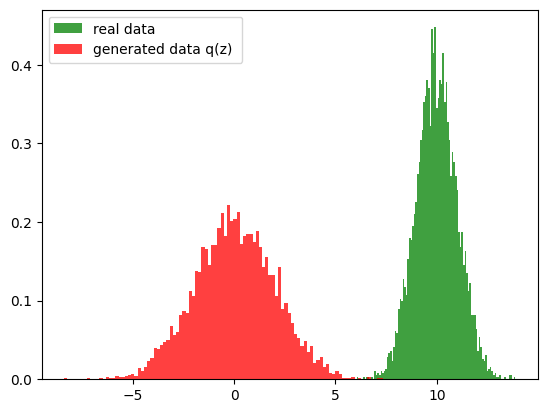

In [6]:
plot_distribution(X,Z,discriminator=None,density=True)

Vamos a crear nuestro primer modelo generativo sumando 10 a cada muestra de $z$. Llamaremos al resultados $\hat{\mathbf{x}}$  ya que es una aproximación de $\mathbf{x}$. No es dificil mostrar que $\hat{\mathbf{x}} \sim \mathcal{N}(\mathbf{x}|10,1)$.


In [8]:
Xhat=Z+10

Veamos que la media y la desviación estándar son casi idénticas.


In [9]:
print("mean:",np.mean(Xhat))
print("standard deviation:",np.std(Xhat))

mean: 10.026404
standard deviation: 1.9671243


Lo mismo ocurre con los histogramas


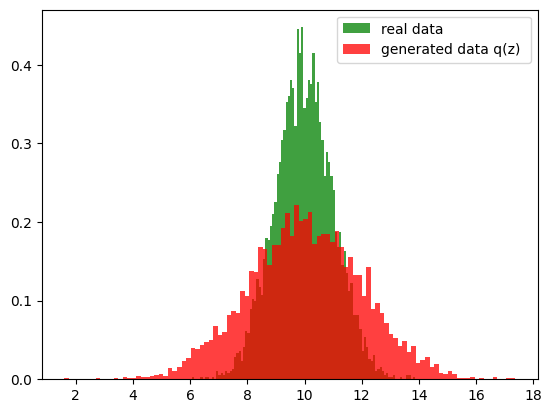

In [10]:
plot_distribution(X,Xhat,discriminator=None,density=True)

En el caso anterior, dado que simplemente sumamos 10 a la variable latente $z$, transformamos $z$ usando una función determinista. Podemos llamar a esto un mod generativo implícito.

## El Generador


Hay dos redes involucradas en una GAN, el Generador y el Discriminador. Primero comprendamos la red Generator.

El Generador es una red neuronal denotada por $G$; La idea es que una red neuronal pueda aproximarse a cualquier función, por lo que debería poder generar muestras de datos a partir de cualquier tipo de distribución.

Nuestro objetivo es convertir las muestras, $\mathbf{z}$, en una que se aproxime a $\hat{\mathbf{x}}$, es decir, $\hat{\mathbf{x}}=G(\mathbf{z })$. Construyamos un generador simple $G(\mathbf{z})=\mathbf{W}^{T}\mathbf{z}+\mathbf{b} $ usando Keras.

La siguiente es una función que genera un generador utilizando el objeto de modelo secuencial de Kera.


In [11]:
def make_generator_model():
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1))
    return generator

Podemos usar el Generador para convertir $\mathbf{z}$ y hacer una predicción $\hat{\mathbf{x}}$, y mostrar el histograma de las distribuciones de $\hat{\mathbf{x}}$ y $\mathbf{x}$. Como el modelo no está entrenado, las distribuciones entrenadas son bastante diferentes:

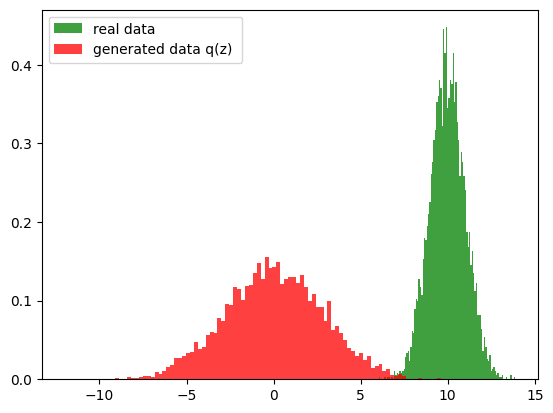

In [12]:
generator=make_generator_model()

Xhat = generator(Z, training=False)
plot_distribution(real_data=X,generated_data=Xhat)

Discutiremos el uso del parámetro `training=False` más adelante.


## El Discriminador


El discriminador $D(\mathbf{x})$ es una red neuronal que aprende a distinguir entre muestras reales y generadas. El discriminador más simple es una función de regresión logística simple. Creemos un discriminador en Keras con una capa densa; Dejamos de lado la función logística ya que se incorporará a la función de costos, que es la convención en Keras.


In [13]:
def make_discriminator_model():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=make_discriminator_model()

El discriminador y el generador se inicializan aleatoriamente, pero podemos trazar la salida de cada uno y compararla con la distribución de datos verdadera, con los datos generados en rojo y los datos reales en verde, y la función logística en función del eje x. También incluimos el umbral. Si la salida de la función logística es inferior a 0,5, la muestra se clasifica como datos generados; por el contrario, si la salida es mayor que 0,5, la muestra se clasificará como datos que provienen de la distribución real.


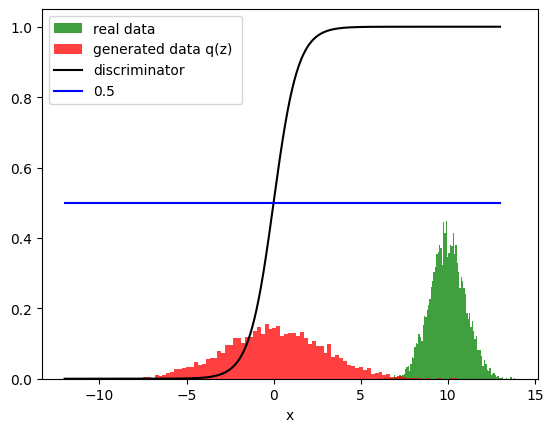

In [15]:
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator)

Aplicando la función sigmoide a la salida del discriminador, obtenemos las probabilidades de que las muestras pertenezcan a la distribución real. Podemos contar el número de muestras verdaderas que el discriminador clasifica correctamente.

Para los datos reales, el discriminador asigna con éxito una probabilidad superior a 0,5 para las 5000 muestras:


In [16]:
py_x=tf.math.sigmoid(discriminator(X,training=False))
np.sum(py_x>0.5)

5000

Para los datos generados, solo 1425 de las 5000 muestras se clasifican con más del 50% de posibilidades de provenir de la distribución real.

In [17]:
py_x=discriminator(Xhat)
np.sum(py_x>0.5)

2258

También podemos usar lo siguiente para encontrar el valor promedio de la función sigmoide para todas las muestras.


In [18]:
def get_accuracy(X,Xhat):
    total=0
    py_x=tf.math.sigmoid(discriminator(X,training=False))
    total=np.mean(py_x)
    py_x=tf.math.sigmoid(discriminator(Xhat,training=False))
    total+=np.mean(py_x)
    return total/2

In [19]:
get_accuracy(X,Xhat)

0.7526005506515503

En muchos casos, podemos estudiar la diferencia en la distribución;

En este caso, el discriminador se llama <a href='https://arxiv.org/pdf/2107.06700.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperS mataNetworkML311Coursera35714171-2022-01- 01'>Crítica</a>, una función de valor real.


##  Loss Fucntion en GANs

Las GAN convierten un problema de aprendizaje no supervisado en uno supervisado.
En lugar de formular el problema como un juego minimax para dos jugadores con una función de valor como en <a href='https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork- Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01'>\[1]</a>, podemos tratar el problema de maximizar la familiar probabilidad logarítmica de la función logística de forma análoga a minimizar la pérdida de entropía cruzada, y luego incorporar el generador y el discriminador.

## Discriminador

Para entrenar el GANS, comenzamos con la maximización estándar de la probabilidad del discriminador para el conjunto de datos estándar $\mathcal{D}={{(x\_1, y\_1), ..., (x_N, y_N )}}$:

$$V(D)=\sum\_{n=1}^N \left( y_n \ln(D(\mathbf{x}\_n))+(1-y_n) \ln(1-D(\ matemáticasbf{x}\_n))\right)$$

Donde $y=1$ para muestras de la distribución verdadera y $y=0$ para muestras del generador. El objetivo es maximizar este término con respecto a $D$:

$$max\_{D}(V(D))$$


Para incorporar también las muestras generadas, aumentamos el lado derecho de la ecuación con la $k$ésima muestra generada $\hat{\mathbf{x}}\_k$. Como no son parte del conjunto de datos $k \notin \mathcal{D} $, tenemos que incluir una segunda suma donde $y=0$. Finalmente, combinando los casos de $y=1$ y $y=0$, obtenemos:

$$V(D)=\sum\_{ n \in \mathcal{D}} \ln(D(\mathbf{x}*n))+\sum*{k \notin \mathcal{D}} \ ln(1-D(\sombrero{\mathbf{x}}\_k) ) $$


### Generador

Para el generador simplemente reemplazamos $\hat{\mathbf{x}}\_k$ con $G(\mathbf{z}\_k)$ .

$$V(G,D)=\sum\_{n \in \mathcal{D}} \ln(D(\mathbf{x}*n))+\sum*{k \notin \mathcal{D} } \ln(1-D(G(\mathbf{z}\_k))) $$

Como se trata de un problema de estimación de densidad, es común reemplazar la suma con el valor esperado como en <a href='https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA -SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01' >\[1]</a>. Reemplazamos las sumatorias con una expectativa donde $p(\mathbf{x})$ es la distribución verdadera y $p(\mathbf{z})$ es la distribución de $\mathbf{z}$.

$$V(D,G)=\mathbb{E}*{x\sim p(\mathbf{x})} \ln(D(\mathbf{x})) + \mathbb{E}*{\mathbf {z} \sim p(\mathbf{z})} \ln(1-D(G(\mathbf{z}) )) $$

Mientras intentamos engañar al discriminador, nos gustaría encontrar un $G$ que minimice la expresión anterior, como por ejemplo:

$$mín\_{G} máx\_{D} V(D,G)$$


## Training GANS

### Generador:  Entrenamiento

Las GAN son bastante difíciles de entrenar, incluso para un ejemplo simple. Empecemos por entrenar el generador en la práctica.

Es difícil trabajar con $log(1 − D(G(\mathbf{z})))$ ya que $D(G(\mathbf{z}))$ está cerca de uno o cero durante las primeras iteraciones. Esto se debe a que el generador aún no está entrenado adecuadamente y el discriminador puede distinguir fácilmente entre las muestras generadas y las reales. Por lo tanto maximizamos $log(D(G(\mathbf{z}\_k)) )$.

Aunque la salida del generador pasa a través del discriminador, no actualizamos el generador en el paso de optimización, por lo que configuramos el parámetro `training=False` en los pasos de entrenamiento reales.

En lugar de maximizar el término, podemos tomar el negativo y minimizarlo. La expresión resultante se puede calcular en Keras utilizando la pérdida de entropía cruzada donde todos los valores objetivo se establecen en uno:

$$\sum\_{k \notin \mathcal{D}} log(1 - D(G(\mathbf{z}\_k)) )$$


In [20]:
# This method returns a helper function to compute crossentropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

### Discriminador: entrenamiento

También podemos utilizar la entropía cruzada para entrenar al discriminador; simplemente multiplicamos $V(G,D)$ por un número negativo, establecemos $y=0$ para los valores generados y $y=1$ para los valores reales. No actualizamos los parámetros del generador.

$$V(G)=\sum\_{n \in \mathcal{D}} (\ln(D(\mathbf{x}*n)))+\sum*{k \notin \mathcal{D} } \ln(1-D(G(\mathbf{z}\_k) )) $$


El primer término es la pérdida real y el segundo es la pérdida falsa en Keras.


In [21]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

Creamos el optimizador para el discriminador y generador:


In [22]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)

discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)


Ahora entrenamos el modelo; Como el conjunto de datos es pequeño, utilizaremos el descenso de gradiente por lotes.

Para cada iteración generaremos $M$ ejemplos reales ${\mathbf{x}*{1}, ...,\mathbf{x}*{M}}$, estos son de la distribución generadora $p(\mathbf {x})$. Este sería nuestro conjunto de datos real si usáramos datos reales.

Luego generaremos un lote de muestra de $M$ muestras de ruido ${\mathbf{z}*{1}, ...,\mathbf{z}*{M}}$ del ruido anterior $p(\mathbf{z })$ y convierte el resultado en una imagen generada usando el generador ${\hat{\mathbf{x}}*{1}, ...,\hat{\mathbf{x}}*{M}}$.

Determinamos la salida del discriminador tanto para la muestra real como para la generada. Calculamos la pérdida y luego actualizamos el discriminador y el generador a través de sus respectivos gradientes estocásticos.


La convergencia del entrenamiento GAN es un tema en sí mismo. Pero exploremos un método que funcione para este conjunto de datos simple. Intuitivamente, sabemos que si nuestros datos generados son idénticos a nuestros datos reales, la probabilidad de clasificar correctamente es aleatoria. Por lo tanto, si los datos generados y los reales son de igual proporción, $D(\mathbf{x}\_n)=0.5$ y $D(\hat{\mathbf{x}}\_n)=0.5$.

Solo mostramos iteraciones en las que la salida promedio del discriminador se acerca al 50% tanto para los datos generados como para los datos reales.


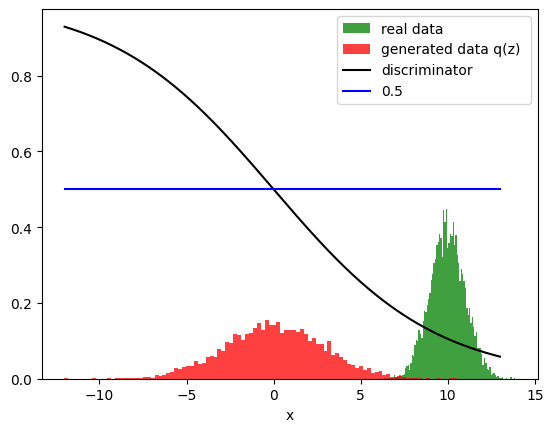

epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


0.7535523176193237


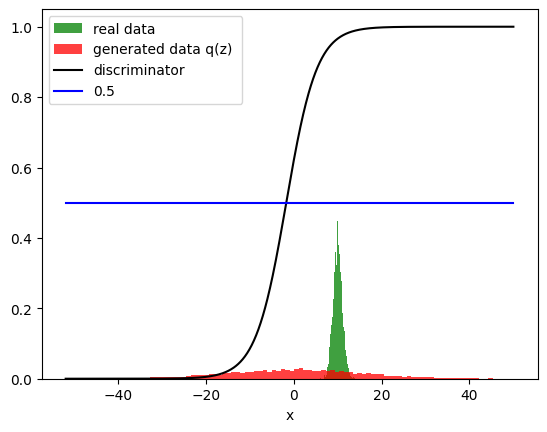

  5%|▌         | 1/20 [00:02<00:54,  2.85s/it]

epoch 0


0.7493507862091064


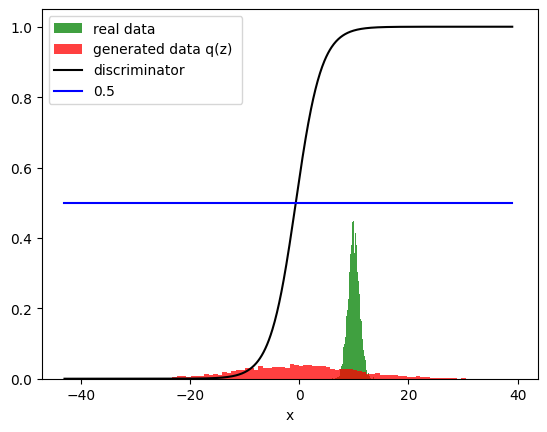

 10%|█         | 2/20 [00:06<00:59,  3.32s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 1


0.7242770195007324


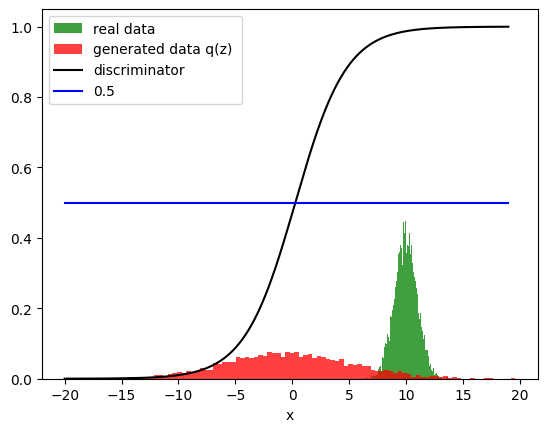

 15%|█▌        | 3/20 [00:08<00:46,  2.71s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 2


0.6791362762451172


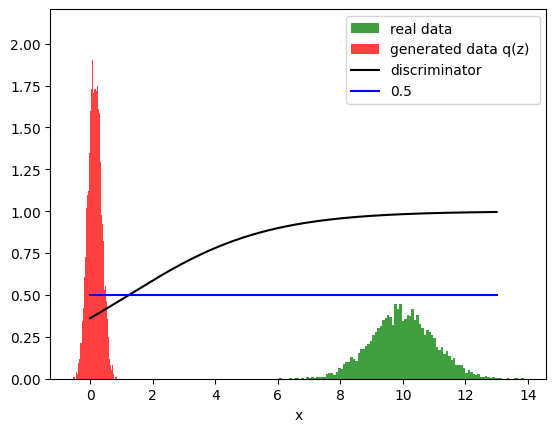

 20%|██        | 4/20 [00:10<00:36,  2.27s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 3


0.6577295660972595


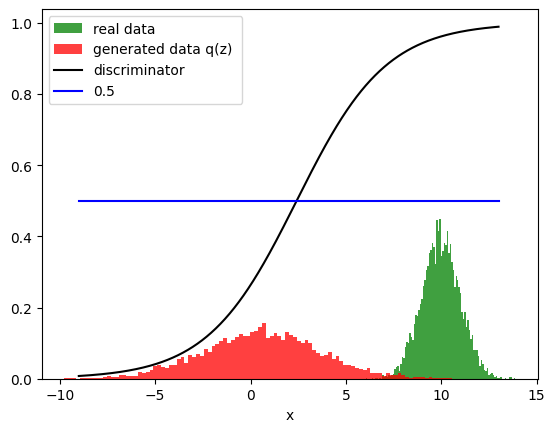

 25%|██▌       | 5/20 [00:11<00:27,  1.86s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 4


0.597999095916748


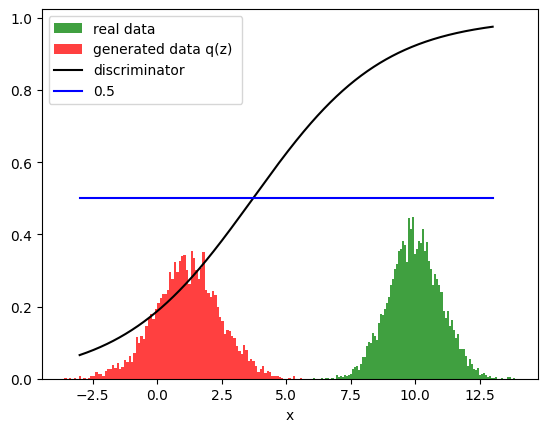

 30%|███       | 6/20 [00:12<00:22,  1.60s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 5


0.5577225685119629


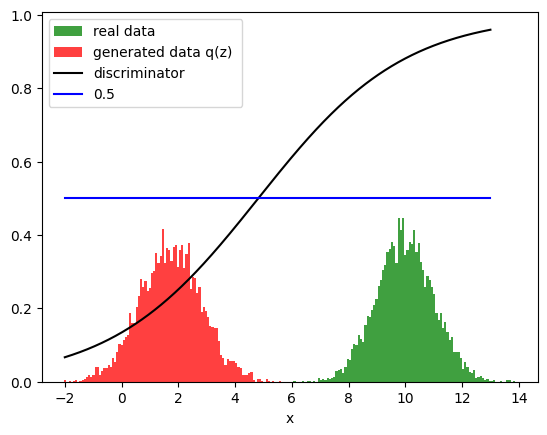

 35%|███▌      | 7/20 [00:13<00:18,  1.44s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 6


0.5501281023025513


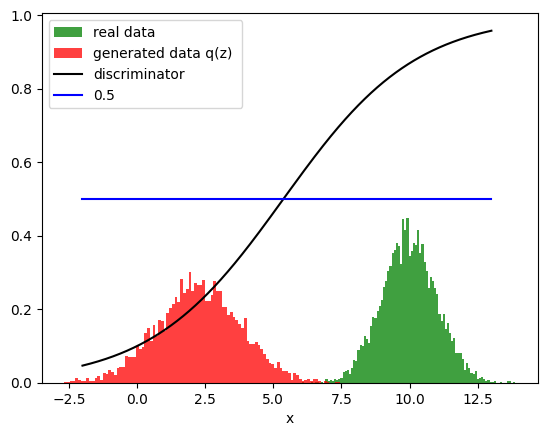

 50%|█████     | 10/20 [00:14<00:07,  1.31it/s]

epoch 7


0.544734537601471


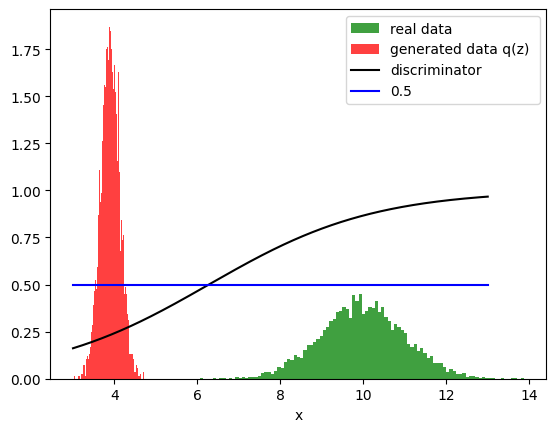

 55%|█████▌    | 11/20 [00:16<00:08,  1.01it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 10


0.5295025110244751


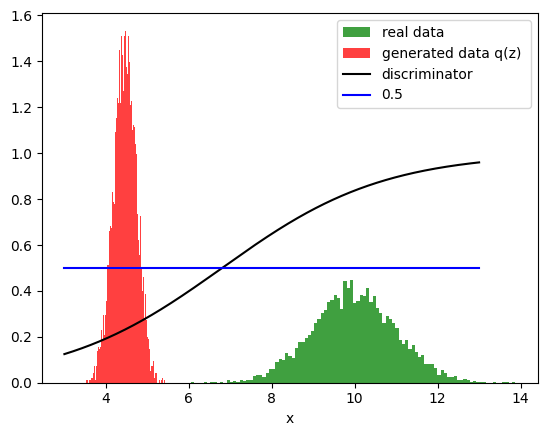

 60%|██████    | 12/20 [00:18<00:09,  1.15s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 11


0.4782257080078125


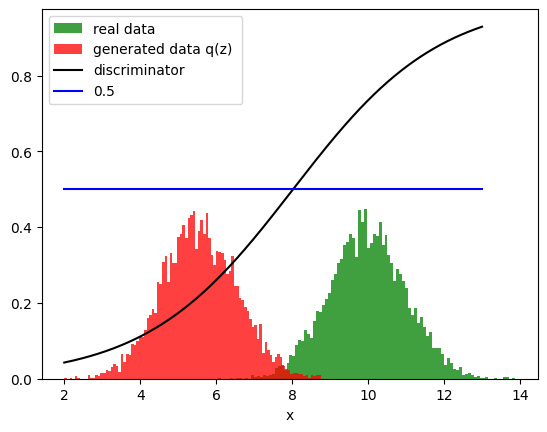

 80%|████████  | 16/20 [00:20<00:02,  1.48it/s]

epoch 13


0.48026272654533386


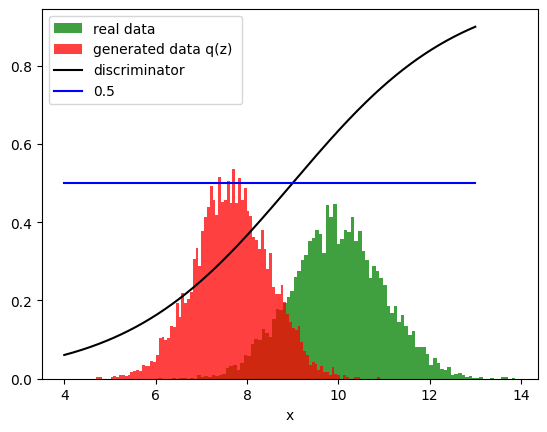

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]

epoch 17


In [23]:
#paramters for training
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100


#discrimator and gernerator
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Save and display the generator and discriminator if the performance increases
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        generator.save('generator')
        discriminator.save('discriminator')
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

Para obtener más información sobre la capacitación de GAN, consulte lo siguiente: <a href="https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b? utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01">blog</a>. Podemos mostrar el modelo con mejor rendimiento.


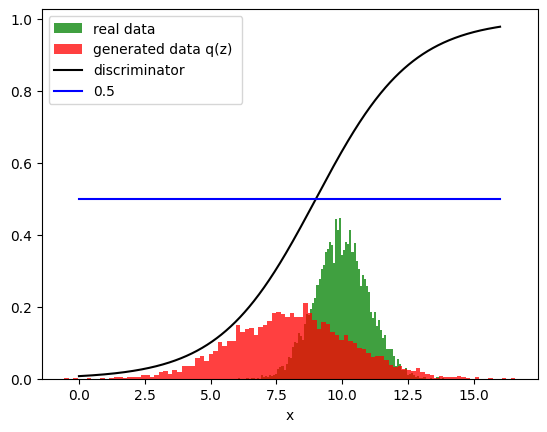

In [24]:
generator=make_generator_model()
generator= models.load_model('generator')
xhat=generator(z)
discriminator=models.load_model('discriminator')
plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )